# TME 9 : Régression & optimisation par descente de gradient

Ce TME a deux objectifs: 
 - acquérir les connaissances de base pour faire face au problème de la régression, c'est à dire de l'estimation d'un score réel correpondant à une situation,
 - travailler sur les techniques d'optimisation par descente de gradient

In [147]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

## Génération de données jouet & construction d'une solution analytique

Dans un premier temps, générons des données jouets paramétriques:
 - $N$: nombre de points à générer
 - $x \in [0, 1]$ tirage avec un simple rand() ou un linspace() -au choix-
     - Si vous optez pour un tirage aléatoire des abscisses, triez les points pour simplifier les traitements ultérieurs
 - $y=ax+b+\epsilon, \epsilon \sim \mathcal N(0,\sigma^2)$
     - Rappel : en multipliant un tirage aléatoire selon une gaussienne centrée réduite par $\sigma$ on obtient le bruit décrit ci-dessus

Afin de travailler sur les bonnes pratiques, nous distinguerons un ensemble d'apprentissage et un ensemble de test.
Les deux sont tirés selon la même distribution. L'ensemble de test comptera -arbitrairement- 1000 points.

In [148]:
def gen_data_lin(a, b, sig, N = 500, Ntest = 1000):
    y_train = np.zeros((N))
    y_test = np.zeros((Ntest))
    mu = 0
    e = mu + sig * np.random.randn(N + Ntest) # de quoi bruiter toutes les données 
    # les échantillons doivent être tirés selon la même distribution, donc aussi en ce qui concerne le bruit.
    X_train = np.random.rand(N) # tirage des x de train
    X_test = np.random.rand(Ntest) # tirage des x de test
    X_train.sort()
    X_test.sort()
    for n in range(N): # création du jeu d'apprentissage
        y_train[n] = a * X_train[n] + b + e[n] # calcul des y
    for n in range(Ntest):# création du jeu de test
        y_test[n] = a*X_test[n] + b + e[N+n] # calcul des y
    return X_train, y_train, X_test, y_test

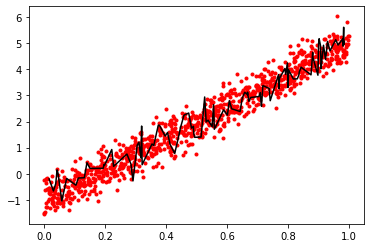

In [149]:
# génération de données jouets:
a = 6.
b = -1.
N = 100
sig = .4 # écart type

X_train, y_train, X_test, y_test = gen_data_lin(a, b, sig, N)
plt.figure()
plt.plot(X_test, y_test, 'r.')
plt.plot(X_train, y_train, 'k')
plt.show()

Vous devez obtenir quelque chose de la forme:
![données jouet](fig/gen_data.png)

## Validation des formules analytiques
Nous avons vu deux types de résolutions analytique: à partir des estimateurs des espérances et co-variances d'une part et des moindres carrés d'autre part. Testons les deux méthodes.

### Estimation de paramètres probabilistes
 - $\hat a = \frac{\mbox{cov}(X,Y)}{\sigma_x^2}$
 - $\hat b = E(Y)−\frac{\mbox{cov}(X,Y)}{\sigma_x^2} E(X)$
 
 Estimer les paramètres, calculer l'erreur au sens des moindres carrés sur les données d'apprentissage et de test, puis tracer la droite de régression

In [150]:
def modele_lin_analytique(X_train, y_train):
    # d'abord, l'estimation des paramètres
    ahat = np.cov(X_train,y_train)[0][1]/np.var(X_train) # application des formules
    bhat = np.mean(y_train) - ahat*np.mean(X_train)
    return ahat, bhat

def erreur_mc(y, yhat):
    # ensuite, l'erreur
    return ((y-yhat)**2).mean()

ahat, bhat = modele_lin_analytique(X_train, y_train)
yhat_train = ahat*X_train + bhat
yhat_test = ahat*X_test + bhat
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat_train, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_test, y_test))

Erreur moyenne au sens des moindres carrés (train): 0.1603151072534987
Erreur moyenne au sens des moindres carrés (test): 0.15705312189064743


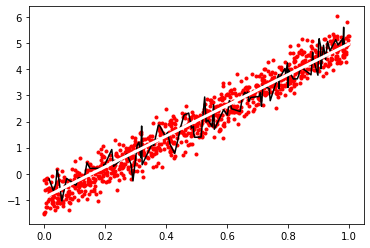

In [151]:
plt.figure()
plt.plot(X_test, y_test, 'r.')
plt.plot(X_train, y_train, 'k')
plt.plot(X_test, yhat_test, 'w', lw=3) # et pour finir, la droite de régression
plt.show()

## Formulation au sens des moindres carrés

Nous partons directement sur une écriture matricielle. Du coup, il est nécessaire de construire la matrice enrichie $Xe$:
    $$Xe = \left[\begin{array}{cc}
                X_0 & 1\\
                \vdots & \vdots\\
                X_N & 1
                \end{array}
                \right] $$
Le code de la fonction d'enrichissement est donné ci-dessous.

Il faut ensuite poser et résoudre un système d'équations linéaires de la forme:
$$ A w = B $$
**Rappel des formules vues en cours/TD:**
$$ A=X^T X$$
$$ B=X^T Y$$
Fonction de résolution: `np.linalg.solve(A,B)`
Vous devez obtenir la même solution que précédemment. 

In [152]:
def make_mat_lin_biais(X): 
    N = len(X)
    return np.hstack((X.reshape(N,1), np.ones((N,1)))) # enrichir une matrice d'une colonne supplémentaire

# construire une matrice enrichie
Xe = make_mat_lin_biais(X_train)
# résoudre un système Aw = B : trouver les coefficients de l'équation linéaire
A = np.dot(Xe.T, Xe) 
B = np.dot(Xe.T, y_train)
w = np.linalg.solve(A,B) 
print(w)

# C'est une équation linéaire, de la forme aX + b. Il y a donc deux coefficients.

[ 5.82612238 -0.8781669 ]


Soit les données polynomiales générées avec la fonction ci-dessous
 - proposer & une solution d'enrichissement (vue en cours et TD) 
 - résoudre analytiquement le problème des moindres carrés
 - calculer l'erreur au sens des moindes carrés en apprentissage ET en test
 - tracer les données et la solution

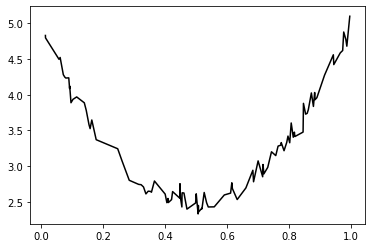

In [153]:
def gen_data_poly2(a, b, c, sig, N=500, Ntest=1000):
    '''
    Tire N points X aléatoirement entre 0 et 1 et génère y = ax^2 + bx + c + eps
    eps ~ N(0, sig^2)
    '''
    X_train = np.sort(np.random.rand(N))
    X_test  = np.sort(np.random.rand(Ntest))
    y_train = a*X_train**2 + b*X_train + c + np.random.randn(N)*sig
    y_test = a*X_test**2 + b*X_test + c + np.random.randn(Ntest)*sig
    return X_train, y_train, X_test, y_test

Xp_train, yp_train, Xp_test, yp_test = gen_data_poly2(10, -10, 5, 0.1, N=100, Ntest=100)
plt.figure()
plt.plot(Xp_train, yp_train, "k")
plt.show()

Erreur moyenne au sens des moindres carrés (train): 0.009166355362776461
Erreur moyenne au sens des moindres carrés (test): 0.008267460159187768


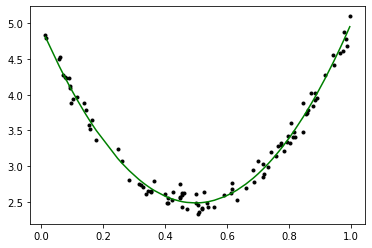

In [154]:
def make_mat_poly_biais(X): 
    N = len(X)
    Xr = X.reshape(N,1)
    return np.hstack((Xr**2, Xr, np.ones((N,1)))) # empiler les termes de degré 2, de degré 1, de degré 0

# créer les matrices enrichies de train et de test
Xe = make_mat_poly_biais(Xp_train)
Xe_t = make_mat_poly_biais(Xp_test)
# lancer la résolution : trouver l'expression du polynôme (trois coefficients)
A = np.dot(Xe.T, Xe)
B = np.dot(Xe.T, yp_train)
w = np.linalg.solve(A,B) 
yhat = w[0]*Xp_train**2 + w[1]*Xp_train + w[2]
yhat_t = w[0]*Xp_test**2 + w[1]*Xp_test + w[2]
# calcul de l'erreur
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat, yp_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t, yp_test))
# visualisation
plt.figure()
plt.plot(Xp_train, yp_train, 'k.')
plt.plot(Xp_train, yhat, 'g')
plt.show()

# Fonction de coût & optimisation par descente de gradient

Comme vu en TD et en cours, nous allons maintenant résoudre le problème de la régression par minimisation d'une fonction de coût:
$$ C = \sum_{i=1}^N (y_i - f(x_i))$$

Soit un problème avec des données $(x_i,y_i)_{i=1,\ldots,N}$, une fonction de décision/prédiction paramétrée par un vecteur $w$ et une fonction de cout à optimiser $C(w)$.
Notre but est de trouver les paramètres $w^\star$ minimisant la fonction de coût:
$$ w^\star = \arg\min_w C(w)$$

l'algorithme de la descente de gradient est le suivant (rappel):

 - $w_0 \leftarrow init$ par exemple : 0
 - boucle
     - $w_{t+1} \leftarrow w_{t} - \epsilon \nabla_w C(w_t)$

Compléter le squelette d'implémentation fourni ci-dessous:


In [155]:
# (re)construction de la matrice contenant les X et un biais
Xe = make_mat_lin_biais(X_train) # dataset linéaire
A = np.dot(Xe.transpose(),Xe)
B = np.dot(Xe.transpose(),y_train)
# obtenir un w optimal à l'instant t
wstar = np.linalg.solve(A,B) 

# et lancer la descente
def descente_grad_mc(X, y, eps=1e-4, nIterations=100):
    w = np.zeros(X.shape[1]) # initialisation à 0
    allw = [w]
    for i in range(nIterations):
        Xw_y = np.dot(X,allw[-1]) - y
        w = allw[-1] - eps*np.dot(2*X.T, Xw_y)
        allw.append(w) # stockage de toutes les valeurs intermédiaires pour analyse
    allw = np.array(allw)
    return w, allw # la dernière valeur (meilleure) + tout l'historique pour le plot
    
w, allw = descente_grad_mc(Xe, y_train, eps=1e-4, nIterations=200)

On s'intéresse ensuite à comprendre la descente de gradient dans l'espace des paramètres. Le code ci-dessous permet de tracer le cout pour un ensemble de paramètres (toutes les valeurs de paramètres prises par l'algorithmes au fil du temps).


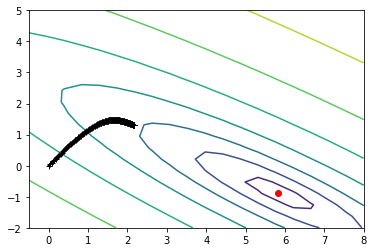

In [156]:
# tracer de l'espace des couts
def plot_parametres( allw, X, y, opti = [], ngrid = 20, extract_bornes=False):
    '''
    Fonction de tracer d'un historique de coefficients
    ATTENTION: ca ne marche qu'en 2D (évidemment)
    Chaque w doit contenir 2 valeurs
    
    Il faut fournir les données (X,y) pour calculer le cout associé 
    à un jeu de paramètres w
    ATTENTION X = forme matricielle des données
    '''
    w_min = [-0.5, -2] # bornes par défaut, uniquement pour notre cas d'usage
    w_max = [8, 5]
    if extract_bornes: # bornes générales
        w_min = np.min(allw,0) # trouver les bornes
        w_max = np.max(allw,0)
    # faire une grille régulière avec tous les couples possibles entre le min et le max
    w1range = np.linspace(w_min[0], w_max[0], ngrid)
    w2range = np.linspace(w_min[1], w_max[1], ngrid)
    w1,w2 = np.meshgrid(w1range,w2range)
    #
    # calcul de tous les couts associés à tous les couples de paramètres
    cost = np.array([[np.log(((X @ np.array([w1i,w2j])-y)**2).sum()) for w1i in w1range] for w2j in w2range])
    #
    plt.figure()
    plt.contour(w1, w2, cost)
    if len(opti) > 0:
        plt.scatter(wstar[0], wstar[1],c='r')
    plt.plot(allw[:,0],allw[:,1],'k+-' ,lw=2 )
    return
    
plot_parametres(allw, Xe, y_train, opti=wstar)
# plt.savefig('fig/grad_descente.png')

# Petite note : on n'obtient pas la "séparation" visible au centre de la figure de référence, 
# qui n'existe que lorsqu'on intègre - par erreur - des données polynomiales au calcul...

# Cette situation est celle d'une convergence incomplète (?).

Vous devez obtenir un image de la forme :
![Descente de gradient](fig/grad_descente.png)

Tester différents jeux de paramètres pour mettre en évidence les phénomènes suivants:
 - Divergence du gradient
 - Convergence incomplète (trop lente ou pas assez d'itération)
 - Convergence idéale: pas de gradient suffisamment grand et nombre d'itérations bien choisi

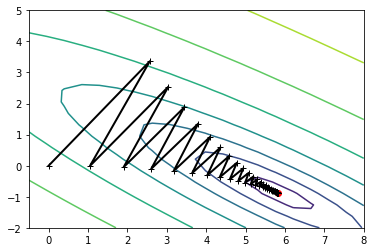

In [165]:
w, allw = descente_grad_mc(Xe, y_train, eps=7e-3, nIterations = 300) 
plot_parametres(allw, Xe, y_train, opti=wstar)
# presque une situation de divergence

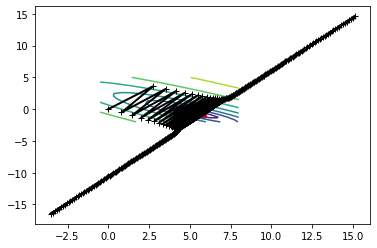

In [167]:
w, allw = descente_grad_mc(Xe, y_train, eps=7.5e-3, nIterations = 300) 
plot_parametres(allw, Xe, y_train, opti=wstar)
# ...le degré d'après

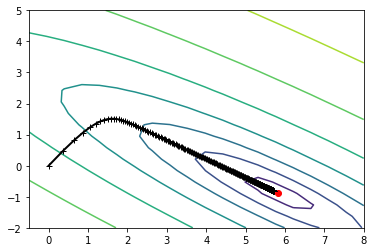

In [168]:
w, allw = descente_grad_mc(Xe, y_train, eps = 1e-3, nIterations = 300)
plot_parametres(allw, Xe, y_train, opti=wstar)
# convergence idéale : un gradient peu conséquent, et le centre rouge est atteint en un nombre d'itérations raisonnable.

# Passage sur des données réelles

Après avoir étudié trois manières de faire face au problème de la régression, nous proposons d'étudier un cas réel: la prédiction de la consommation des voitures en fonction de leurs caractéristiques.

Dans le cas présent, nous allons baser la solution sur la résolution analytique du problème des moindres carrés (`np.linalg.solve(A,B)`), qui semble la mieux adaptée au problème qui nous intéresse.

Le jeu de données est issu des datasets UCI, un répertoire parmi les plus connus en machine learning. Les données **sont déjà téléchargées et présentes dans le tME** mais vous voulez plus d'informations:
https://archive.ics.uci.edu/ml/datasets/auto+mpg

![voiture](fig/Large9.jpg)

Après avoir importé les données (fonction fournie), vous construirez une solution optimale et l'évaluerez au sens des moindres carrés en apprentissage et en test.


In [171]:
import pandas as pd
# Chargement des données
data = pd.read_csv('data/auto-mpg.data', delimiter='\s+', header=None) # comme np.loadtxt mais en plus robuste
# remplacement des données manquantes '?' => Nan pour travailler sur des nombres
data.iloc[:,[3]] = data.iloc[:,[3]].replace('?', None)
data.iloc[:,[3]] = data.iloc[:,[3]].astype(float)
# remplacement des valeurs manquantes par la moyenne
data.iloc[:,[3]] = data.iloc[:,[3]].fillna(data.iloc[:,[3]].mean())

print(data.head()) # visualiser ce qu'il y a dans les données

X = np.array(data.values[:,1:-2], dtype=np.float64)
y = np.array(data.values[:,0], dtype=np.float64)

      0  1      2      3       4     5   6  7                          8
0  18.0  8  307.0  130.0  3504.0  12.0  70  1  chevrolet chevelle malibu
1  15.0  8  350.0  165.0  3693.0  11.5  70  1          buick skylark 320
2  18.0  8  318.0  150.0  3436.0  11.0  70  1         plymouth satellite
3  16.0  8  304.0  150.0  3433.0  12.0  70  1              amc rebel sst
4  17.0  8  302.0  140.0  3449.0  10.5  70  1                ford torino


In [172]:
def separation_train_test(X, y, pc_train=0.75):
    index = list(range(len(y)))
    np.random.shuffle(index) # mélanger les données
    napp = int(len(y)*pc_train)
    X_train, y_train = X[index[:napp]], y[index[:napp]] # séparer selon la liste d'index obtenue : jusqu'à une certaine limite
    X_test, y_test = X[index[napp:]], y[index[napp:]] # et après ladite limite
    # les X et les y sont toujours rangés en correspondance.
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = separation_train_test(X, y, pc_train=0.75)
print(X_train.shape)

(298, 6)


In [173]:
# une petite modification qui sied aux datasets à plusieurs colonnes
def make_mat_lin_biais_adapted(X):
    N,L = X.shape
    return np.hstack((X.reshape(N,L),np.ones((N,1))))

# même processus que précédemment
Xe = make_mat_lin_biais_adapted(X_train.copy())
Xe_t = make_mat_lin_biais_adapted(X_test.copy())
Ye = y_train
A = np.dot(Xe.T, Xe)
B = np.dot(Xe.T, Ye)
w = np.linalg.solve(A, B)
print(w)
yhat = np.dot(Xe,w)
yhat_t = np.dot(Xe_t,w)
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t, y_test))

# L'erreur se lit en litres d'essence, elle est donc relativement peu importante. 

[-7.11103791e-02  4.15797323e-03  1.06754874e-02 -7.07267241e-03
  2.61509275e-01  7.38183194e-01 -1.71407513e+01]
Erreur moyenne au sens des moindres carrés (train): 10.50206960703053
Erreur moyenne au sens des moindres carrés (test): 15.628844905881001


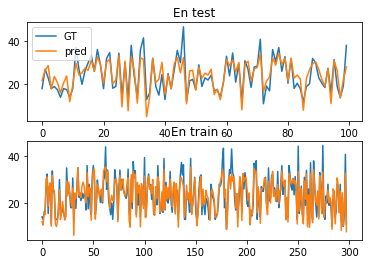

In [174]:
def plot_y(y_train, y_test, yhat, yhat_t):
    # tracé des prédictions:
    plt.figure()
    plt.subplot(211)
    plt.plot(y_test, label="GT")
    plt.plot(yhat_t, label="pred")
    plt.title('En test')
    plt.legend()
    plt.subplot(212)
    plt.plot(y_train, label="GT")
    plt.plot(yhat, label="pred")
    plt.title('En train')
    return
plot_y(y_train, y_test, yhat, yhat_t)

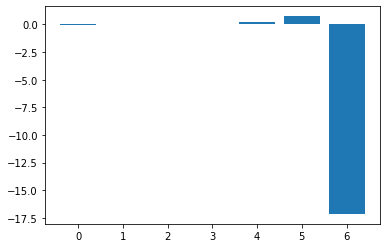

In [175]:
# interprétation des poids
plt.figure()
plt.bar(np.arange(len(w)), w)
plt.show()

## Normalisation

Sur le diagramme ci-dessus, on ne voit pas grand chose pour une raison évidente: on ne peut pas comparer ces poids qui comparent des variables dont les ordres de grandeur sont différents.

Nous allons donc assimiler chaque colonne $X_j$ à une variable suivant une loi normale et nous allons revenir à une Normale centrée réduite selon la formule de base:

$$X_j \sim \mathcal N(\mu_j, \sigma_j^2) $$
$$\Rightarrow Z_j = \frac{X_j - \mu_j}{\sigma_j} \sim \mathcal N(0, 1) $$

Tous les $Z_j$ sont comparables et nous seront en mesure de comprendre l'impact de chaque variables sur les résultats.

**ATTENTION:** on ne se basera que sur les données d'apprentissage pour le calcul des $\{\mu_j, \sigma_j\}$.

Une fois la normalisation effectuée, analyser l'impact des différentes variables descriptives sur la valeur à prédire.

Erreur moyenne au sens des moindres carrés (train): 10.50206960703053
Erreur moyenne au sens des moindres carrés (test): 15.62884490588126


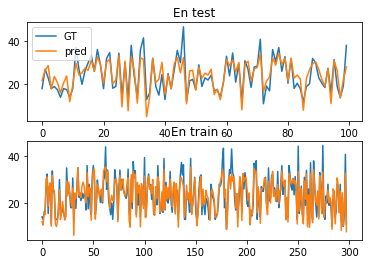

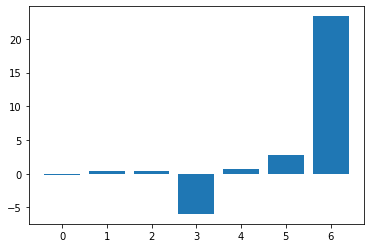

In [176]:
def normalisation(X_train, X_test):
    '''
    Fonction de normalisation des données pour rendre les colonnes comparables
    Chaque variable sera assimilée à une loi normale qu'il faut centrer + réduire.
    ATTENTION: il faut calculer les moyennes et écarts-types sur les données d'apprentissage seulement
    '''
    # 1) calcul des moyennes et écarts types pour chaque colonne
    # 2) normalisation des colonnes
    # 3) Ajout d'un biais: fourni ci-dessous)
    Xn_train = np.zeros(X_train.shape)
    Xn_test = np.zeros(X_test.shape)
    for i in range(X_train.shape[1]):
        mu = X_train[:,i].mean() # fonctions built-in
        sigma = X_train[:,i].std()
        Xn_train[:,i] = (X_train[:,i]-mu)/sigma # revenir à la loi normale centrée réduite
        Xn_test[:,i] = (X_test[:,i]-mu)/sigma # idem
    Xn_train = np.hstack((Xn_train, np.ones((Xn_train.shape[0],1)))) # écrire correctement la matrice avec le biais
    Xn_test = np.hstack((Xn_test, np.ones((X_test.shape[0],1))))
    return Xn_train, Xn_test

# encore une fois, reprise de la même procédure après normalisation
Xn_train, Xn_test = normalisation(X_train, X_test)                    
Xe = Xn_train
Xe_t = Xn_test
A = np.dot(Xe.T,Xe)
B = np.dot(Xe.T,y_train)
w = np.linalg.solve(A,B) 
yhat=0
for i in range(len(w)):
    yhat+=Xe[:,i]*w[i]
yhat_t=0
for i in range(len(w)):
    yhat_t+=Xe_t[:,i]*w[i]         
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t, y_test))

plot_y(y_train, y_test, yhat, yhat_t)
plt.figure()
plt.bar(np.arange(len(w)), w)
plt.show()

# Questions d'ouverture

## Sélection de caractéristiques

Quels sont les résultats obtenus en éliminant toutes les variables qui servent moins?

## Feature engineering

En étudiant la signification des variables du problèmes, on trouve:

1. mpg: continuous 
2. cylinders: multi-valued discrete 
3. displacement: continuous 
4. horsepower: continuous 
5. weight: continuous 
6. acceleration: continuous 
7. model year: multi-valued discrete 
8. origin: multi-valued discrete 

D'après la question précédente, le poids, l'année du modèle et le biais sont des facteurs important pour le calcul de la consommation... Jusqu'ici, nous n'avons pas pris en compte l'origine qui était difficile à coder.

### Encodage de l'origine

La variable origine est accessible de la manière suivante:

```
  origine = data.values[:,-2]
```
Il faut le faire au début du traitement pour bien conserver la séparation en l'apprentissage et le test.

Au moins les deux derniers facteurs discrets pourraient être traités différemment en one-hot encoding:
$$X_j = x \in \{1, \ldots, K\} \Rightarrow [0, 0, 1, 0] \in \{0, 1\}^K$$

La valeur $x$ donne l'index de la colonne non nulle.

### Encodage de l'année

Pour l'année, il est possible de procéder de la même manière, mais il préférable de découper les années en 10 catégories puis d'encoder pour limiter le nombre de dimensions.

Erreur moyenne au sens des moindres carrés (train): 10.746562160425743
Erreur moyenne au sens des moindres carrés (test): 14.587576909606582


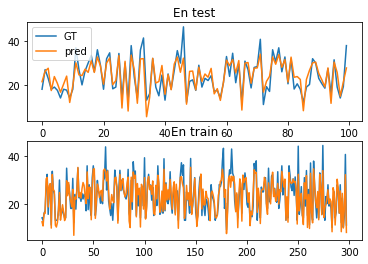

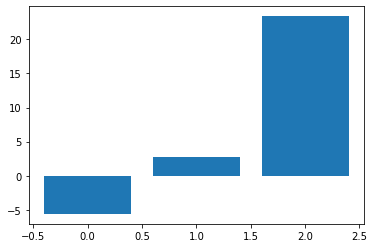

In [177]:
# Sélection de caractéristiques : conserver le poids, l'année du modèle et le biais : c'est ce qui a l'air de compter davantage.
Xcut = np.hstack((Xe[:,3:4],Xe[:,5:])) 
Xcut_t = np.hstack((Xe_t[:,3:4],Xe_t[:,5:]))
# résolution
A = np.dot(Xcut.T,Xcut)
B = np.dot(Xcut.T,y_train)
w = np.linalg.solve(A,B) 
yhat = np.dot(Xcut,w)
yhat_t = np.dot(Xcut_t,w)  
# calcul de l'erreur
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t, y_test))
# visualisation
plot_y(y_train, y_test, yhat, yhat_t)
plt.figure()
plt.bar(np.arange(len(w)), w)
plt.show()

# On constate une amélioration minimale sur l'ensemble de test. 
# En revanche, les résultats sont infinitésimalement moins bons sur le jeu de train : 
# c'est logique puisque le calcul ignore une (toute) petite partie des données. 
# Avoir de bonnes performances en test est cependant suffisant et satisfaisant.

Erreur moyenne au sens des moindres carrés (train): 9.813231041678776
Erreur moyenne au sens des moindres carrés (test): 7.409648468560002


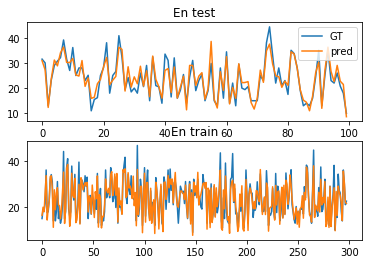

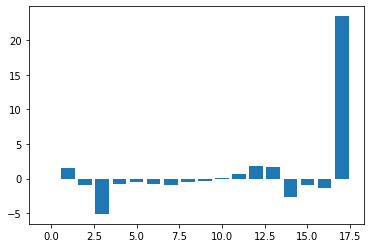

In [191]:
# Encodage de l'origine en one-hot
origine = data.values[:,-2]
N = len(origine)
origine = origine.reshape((N,1))
origine = np.hstack((origine, np.zeros((N,3), dtype=int)))
for o in range(N):
    origine[o, origine[o,0]] = 1
origine = origine[:,1:]

# Encodage des années en one-hot (sur dix catégories)
annees = data.values[:,-3]
intervalles = np.linspace(min(annees), max(annees), 10)
categories = np.zeros((len(annees),10), dtype=int)
for a in range(len(annees)):
    i = 0
    while annees[a] > intervalles[i]:
        i += 1
    categories[a][i] = 1
    
# Réécriture du jeu de données modifié
X = np.array(data.values[:,1:-4], dtype=np.float64)
X = np.hstack((X,categories))
X = np.hstack((X,origine))
y = np.array(data.values[:,0], dtype=np.float64)    
    
# Séparation train/test et normalisation de toutes les données
X_train, y_train, X_test, y_test = separation_train_test(X, y, pc_train=0.75)
Xn_train, Xn_test = normalisation(X_train.copy(), X_test.copy())  
# résolution
Ye = y_train
A = np.dot(Xn_train.T, Xn_train)
B = np.dot(Xn_train.T, Ye)
w = np.linalg.solve(A, B)
yhat = np.dot(Xn_train,w)
yhat_t = np.dot(Xn_test,w)
# calcul de l'erreur
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t, y_test))
# visualisation
plot_y(y_train, y_test, yhat, yhat_t)
plt.figure()
plt.bar(np.arange(len(w)), w)
plt.show()

# La différence d'encodage apporte bien quelque chose à la résolution, puisque l'erreur est moins conséquente 
# (en général, elle est franchement réduite sur le test !)
# On rappelle que l'absence de normalisation de l'erreur (on parle en gallons d'essence) induit en erreur sur 
# la qualité des résultats. Le graphique, cela dit, nous confirme que tout va à peu près bien 
# (couvrance quasi-maximale entre les données réelles en bleu et les prédictions en orange).

# Evidemment, aussi, ceci n'est qu'un exemple possible de séparation train/test sur les données : les résultats varient
# en fonction du random.shuffle effectué dans la fonction de séparation.

# Quand j'y pense, peut-être aurais-je dû prendre en compte aussi la sélection de caractéristiques 
# avant d'ajouter les colonnes encodées.

# Question d'ouverture sur le gradient

## La normalisation a-t-elle un impact sur le gradient?

La normalisation des données peut au moins nous aider à régler plus facilement le pas (qui sera toujours du même ordre de grandeur... Mais cela a-t-il un impact sur la manière dont nous nous rapprochons de la solution optimale?

## Gradient stochastique

Dans la plupart des algorithmes modernes d'optimisation liés aux réseaux de neurones, le gradient est calculé de manière stochastique, sur un exemple à la fois:

- $w_0 \leftarrow init$ par exemple : 0
- boucle
     - tirage d'une donnée $i$: $(x_i,y_i)$
     - $w_{t+1} \leftarrow w_{t} - \epsilon \nabla_w C_i(w)$


Etudier le fonctionnement de cet algorithme sur les exemples jouets précédents.

## Amélioration du gradient

Le blog de S. Ruder explique particulièrement bien les améliorations possibles sur les descentes de gradient.

https://ruder.io/optimizing-gradient-descent/

Comparer une descente de gradient stochastique avec et sans moment sur les données jouets des premières questions.

In [1]:
# La situation de ces derniers jours ne m'a pas permis d'aller plus loin.
# Je tente la suite en cette fin de semaine.